In [1]:
# Forces the notebook to always reload packages.
%reload_ext autoreload
%autoreload 2

## Dataset loading

### Regular dataset loading

In [2]:
from python_proj.utils.util import Counter
import python_proj.utils.exp_utils as exp_utils

# Defines a number of constants.

file_name = "dataset_transformed"
base_path = exp_utils.BASE_PATH
data_path = f"{base_path}/final_data/{file_name}.csv"
figure_base_path = f"{base_path}/figures/modelling/{file_name}/rf_nftc/"

# Meta stuff.
pr_merged_key = "PullRequestIsMerged"
ftc_key = "SubmitterIsFirstTimeContributor"
seed_counter = Counter()

In [3]:
import pandas as pd
import numpy as np
import json


# Loads regular dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)

# Creates sub-datasets.
metadata_fields = ["ID", "Project Name", "Submitter ID", "PR Number", "Closed At"]
dependent_fields = [pr_merged_key]

df.describe()

,ID,Submitter ID,PR Number,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),...,ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedEcosystemSecondOrderDegreeCentrality),ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality),ln(1 + EcosystemLinkIntensity),ln(1 + IntraProjectLinkIntensity)
count,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,...,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06
mean,1.473092e+08,5.092504e+06,8.089130e+02,5.029367e-01,4.028501e-01,9.853429e-02,3.751776e-01,5.922709e-02,4.195426e-01,1.183858e-01,...,1.144450e-02,1.968795e-02,7.962418e-02,1.344287e-01,9.542167e-03,1.752697e-02,6.396780e-02,6.040052e-02,2.195312e-02,4.472791e-02
std,9.954409e+07,7.968202e+06,2.304617e+03,4.710606e-01,4.523397e-01,2.907111e-01,4.479337e-01,2.285036e-01,2.256901e-01,7.147764e-02,...,5.396848e-02,8.007560e-02,1.179799e-01,1.750052e-01,5.263118e-02,8.245257e-02,9.934566e-02,1.002992e-01,8.741610e-02,1.013945e-01
min,6.870000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.924867e+07,4.674710e+05,5.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.365158e-01,7.525668e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.366714e+08,1.633887e+06,1.990000e+02,6.800000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.433349e-01,7.525668e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,7.753347e-02,0.000000e+00,0.000000e+00,8.453635e-03,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.260994e+08,6.254382e+06,6.840000e+02,1.000000e+00,9.391304e-01,0.000000e+00,9.230769e-01,0.000000e+00,5.863557e-01,1.505134e-01,...,0.000000e+00,0.000000e+00,1.416667e-01,2.326004e-01,0.000000e+00,0.000000e+00,9.892883e-02,8.837267e-02,0.000000e+00,2.582313e-02
max,3.617756e+08,5.973444e+07,8.297600e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [4]:
print(list(df.columns))

['ID', 'Project Name', 'Submitter ID', 'PR Number', 'Closed At', 'PullRequestIsMerged', 'ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'IntraProjectSubmitterPullRequestSuccessRate', 'EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'SubmitterIsFirstTimeContributor', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystem

In [ ]:
intra_collab_fields = [
    "ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality)",
    "ln(1 + IntraProjectLinkIntensity)",
]

df = df.drop(intra_collab_fields, axis=1)

In [5]:
# Identifieds independent / predictor fields.


def is_independent_field(field: str) -> bool:
    return field not in metadata_fields and field != pr_merged_key


independent_fields = list(filter(is_independent_field, df.columns))

In [6]:
# Calculates class imbalance.
class_counts = df[pr_merged_key].value_counts()
class_imbalance = class_counts[True] / class_counts[False]
print(f"{class_imbalance=}")

class_imbalance=3.6991542286634957


### Sample only PRs by first-time contributors

In [7]:
# Filters data
df = df[df[ftc_key] == True]
df = df.drop([ftc_key], axis=1)
independent_fields.remove(ftc_key)
print(f"{len(df)=}")

# Recalculates class imbalance.
class_counts = df[pr_merged_key].value_counts()
class_imbalance = class_counts[True] / class_counts[False]
print(f"{class_imbalance=}")

# Resets indices.
df = df.reset_index(drop=True)
print(independent_fields)

df.describe()

len(df)=789389
class_imbalance=5.996516760321202


['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'IntraProjectSubmitterPullRequestSuccessRate', 'EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 

,ID,Submitter ID,PR Number,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),...,ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedEcosystemSecondOrderDegreeCentrality),ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality),ln(1 + EcosystemLinkIntensity),ln(1 + IntraProjectLinkIntensity)
count,7.893890e+05,7.893890e+05,789389.000000,789389.000000,789389.000000,789389.000000,789389.000000,789389.000000,789389.000000,789389.000000,...,789389.000000,789389.000000,789389.000000,789389.000000,789389.000000,789389.000000,789389.000000,789389.000000,789389.000000,789389.000000
mean,1.613374e+08,5.071217e+06,929.996330,0.774881,0.477277,0.138873,0.439422,0.077817,0.380645,0.124870,...,0.016136,0.027668,0.091486,0.155980,0.012445,0.022748,0.072195,0.088793,0.026830,0.065518
std,9.890446e+07,7.946069e+06,2552.602012,0.362156,0.456992,0.336869,0.456628,0.259218,0.217298,0.075795,...,0.063825,0.093934,0.124459,0.183676,0.060300,0.093821,0.103604,0.111771,0.097241,0.119149
min,6.870000e+02,1.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.601776e+07,4.540660e+05,68.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.198106,0.075257,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.561170e+08,1.606068e+06,255.000000,0.977273,0.545455,0.000000,0.083333,0.000000,0.393710,0.075257,...,0.000000,0.000000,0.000000,0.077533,0.000000,0.000000,0.020509,0.044760,0.000000,0.000000
75%,2.410351e+08,6.193135e+06,806.000000,1.000000,0.967742,0.000000,0.960396,0.000000,0.545946,0.150513,...,0.000000,0.000000,0.141667,0.277955,0.000000,0.000000,0.114672,0.140823,0.000000,0.080350
max,3.617734e+08,5.943086e+07,82974.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.993928,...,1.000000,1.000000,0.854348,0.886162,0.999796,1.000000,0.922599,1.000000,1.000000,1.000000


## Model Creation

In [8]:
k = 5
print(f"Using {k=} folds.")

Using k=5 folds.


Generates a number of feature groups that are relevant later in the pipeline:
- control variables
- intra-project experience
- ecosystem experience
- dependency ecosystem experience
- inverse dependency ecosystem experience
- non-dependency ecosystem experience
- collaboration variables

In [9]:
from enum import Enum
from python_proj.utils.util import get_matching

# Defines feature groups


class FeatureGroups(Enum):
    Control = 1
    Intra = 2
    Eco = 3
    DEco = 4
    IDEco = 5
    NDEco = 6
    Coll = 7


var_group_regex_patterns = [
    (FeatureGroups.Control, r".*Control.*"),
    (
        FeatureGroups.Intra,
        r"^(?:(?!Control|Degree|Link).)*Intra(?:(?!Control|Degree|Link).)*$",
    ),
    (FeatureGroups.Eco, r"^(?:(?!Dependency).)*Ecosystem(?:(?!Degree|Link).)*$"),
    (FeatureGroups.DEco, r"^(?!.*(Inverse|Non)).*(?=Dependency).*"),
    (FeatureGroups.IDEco, r".*(?=Inverse).*"),
    (FeatureGroups.NDEco, r".*(?=NonDependency).*"),
    (FeatureGroups.Coll, r"^(?:(?!Intra).)*(Weighted|LinkIntensity)(?:(?!Intra).)*$"),
]

# Resolves the regex patterns to generate lists of fields.
var_groups = {
    str(name): list(get_matching(independent_fields, pattern))
    for name, pattern in var_group_regex_patterns
}


print("Feature groups:")
print(json.dumps(var_groups, indent=2))

Feature groups:
{
  "FeatureGroups.Control": [
    "ControlIntegratedBySameUser",
    "ControlPullRequestHasComments",
    "ControlPullRequestHasCommentByExternalUser",
    "ControlHasHashTagInDescription",
    "ln(1 + ControlPullRequestLifeTimeInMinutes)",
    "ln(1 + ControlNumberOfCommitsInPullRequest)",
    "ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)"
  ],
  "FeatureGroups.Intra": [
    "IntraProjectSubmitterPullRequestSuccessRate",
    "ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)",
    "ln(1 + IntraProjectSubmitterPullRequestCommentCount)",
    "ln(1 + IntraProjectSubmitterIssueSubmissionCount)",
    "ln(1 + IntraProjectSubmitterIssueCommentCount)"
  ],
  "FeatureGroups.Eco": [
    "EcosystemExperienceSubmitterPullRequestSuccessRate",
    "ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)",
    "ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)",
    "ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)",
    "ln(1 + Ecosyst

In [10]:
from wmutils.collections.list_access import flatten


def get_feature_groups(*feature_groups) -> list[str]:
    return list(flatten(var_groups[str(group)] for group in feature_groups))

### Full Model

In [11]:
from python_proj.modelling.notebooks.random_forest.rf_functions import (
    kfold_rf_evaluation,
)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, independent_fields, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics full model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

random_state=43

random_state=43

random_state=43

random_state=43

random_state=43

metrics={'accuracy': 0.930097923713247, 'precision': 0.9420194929553399, 'recall': 0.9786108912868227, 'f1': 0.9599666267638843}


Confusion matrix:
[[ 14525   8144]
 [  2892 132317]]


Classification report:

              precision    recall  f1-score   support

       False       0.83      0.64      0.72     22669
        True       0.94      0.98      0.96    135209

    accuracy                           0.93    157878
   macro avg       0.89      0.81      0.84    157878
weighted avg       0.93      0.93      0.93    157878


metrics={'accuracy': 0.930097923713247, 'precision': 0.9428025059580722, 'recall': 0.9776544580096189, 'f1': 0.9599122399163083}


Confusion matrix:
[[ 14712   8016]
 [  3020 132130]]


Classification report:

              precision    recall  f1-score   support

       False       0.83      0.65      0.73     22728
        True       0.94      0.98      0.96    135150

    accuracy                           0.93    157878
   macro avg       0.89      0.81      0.84    157878
weighted avg       0.93      0.93      0.93    157878


metrics={'accuracy': 0.9314724027413572, 'precision': 0.9437274429266, 'recall': 0.9784922427409474, 'f1': 0.9607954689577951}


Confusion matrix:
[[ 14487   7905]
 [  2914 132572]]


Classification report:

              precision    recall  f1-score   support

       False       0.83      0.65      0.73     22392
        True       0.94      0.98      0.96    135486

    accuracy                           0.93    157878
   macro avg       0.89      0.81      0.84    157878
weighted avg       0.93      0.93      0.93    157878


metrics={'accuracy': 0.9316809921647865, 'precision': 0.9440172035660372, 'recall': 0.9784203456877593, 'f1': 0.9609109424717505}


Confusion matrix:
[[ 14517   7862]
 [  2924 132574]]


Classification report:

              precision    recall  f1-score   support

       False       0.83      0.65      0.73     22379
        True       0.94      0.98      0.96    135498

    accuracy                           0.93    157877
   macro avg       0.89      0.81      0.85    157877
weighted avg       0.93      0.93      0.93    157877


metrics={'accuracy': 0.9312570465802709, 'precision': 0.9437906351030195, 'recall': 0.9779840260316521, 'f1': 0.9605831356981758}


Confusion matrix:
[[ 14782   7876]
 [  2977 132243]]


Classification report:

              precision    recall  f1-score   support

       False       0.83      0.65      0.73     22658
        True       0.94      0.98      0.96    135220

    accuracy                           0.93    157878
   macro avg       0.89      0.82      0.85    157878
weighted avg       0.93      0.93      0.93    157878



Performance metrics full model:
f1_scores=[0.9599666267638843, 0.9599122399163083, 0.9607954689577951, 0.9609109424717505, 0.9605831356981758]
f1_mean=0.9604336827615828, f1_std=0.0004173838063100865


### Control + Intra-project Model

In [12]:
contr_with_intra = get_feature_groups(FeatureGroups.Control, FeatureGroups.Intra)
print(contr_with_intra)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, contr_with_intra, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics control + intra model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'IntraProjectSubmitterPullRequestSuccessRate', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + IntraProjectSubmitterIssueSubmissionCount)', 'ln(1 + IntraProjectSubmitterIssueCommentCount)']


random_state=45

random_state=45

random_state=45

random_state=45

random_state=45

metrics={'accuracy': 0.9262341808231672, 'precision': 0.942018641962973, 'recall': 0.9740096817993978, 'f1': 0.9577470920740423}


Confusion matrix:
[[ 14242   8124]
 [  3522 131990]]


Classification report:

              precision    recall  f1-score   support

       False       0.80      0.64      0.71     22366
        True       0.94      0.97      0.96    135512

    accuracy                           0.93    157878
   macro avg       0.87      0.81      0.83    157878
weighted avg       0.92      0.93      0.92    157878


metrics={'accuracy': 0.9248787038092704, 'precision': 0.9407697790449038, 'recall': 0.973808469824406, 'f1': 0.9570040603248261}


Confusion matrix:
[[ 14028   8310]
 [  3550 131990]]


Classification report:

              precision    recall  f1-score   support

       False       0.80      0.63      0.70     22338
        True       0.94      0.97      0.96    135540

    accuracy                           0.92    157878
   macro avg       0.87      0.80      0.83    157878
weighted avg       0.92      0.92      0.92    157878


metrics={'accuracy': 0.9241878170981207, 'precision': 0.9396477786036938, 'recall': 0.9738875349092175, 'f1': 0.9564613230024919}


Confusion matrix:
[[ 14440   8444]
 [  3525 131468]]


Classification report:

metrics={'accuracy': 0.9240742852075653, 'precision': 0.9396451310928333, 'recall': 0.9737769746878564, 'f1': 0.956406629014485}


Confusion matrix:
[[ 14398   8446]
 [  3541 131493]]


Classification report:

              precision    recall  f1-score   support

       False       0.80      0.63      0.71     22884
        True       0.94      0.97      0.96    134993

    accuracy                           0.92    157877
   macro avg       0.87      0.80      0.83    157877
weighted avg       0.92      0.92      0.92    157877


              precision    recall  f1-score   support

       False       0.80      0.63      0.71     22844
        True       0.94      0.97      0.96    135034

    accuracy                           0.92    157878
   macro avg       0.87      0.80      0.83    157878
weighted avg       0.92      0.92      0.92    157878


metrics={'accuracy': 0.9251574000177352, 'precision': 0.9413939809262749, 'recall': 0.9733843110625608, 'f1': 0.9571219136922473}


Confusion matrix:
[[ 14184   8210]
 [  3606 131878]]


Classification report:

              precision    recall  f1-score   support

       False       0.80      0.63      0.71     22394
        True       0.94      0.97      0.96    135484

    accuracy                           0.93    157878
   macro avg       0.87      0.80      0.83    157878
weighted avg       0.92      0.93      0.92    157878



Performance metrics control + intra model:
f1_scores=[0.9577470920740423, 0.9570040603248261, 0.9564613230024919, 0.956406629014485, 0.9571219136922473]
f1_mean=0.9569482036216185, f1_std=0.0004902802691767377


### Collaboration and Ecosystem Model

In [13]:
non_control_intra_fields = get_feature_groups(
    FeatureGroups.Eco,
    FeatureGroups.DEco,
    FeatureGroups.IDEco,
    FeatureGroups.NDEco,
    FeatureGroups.Coll,
)
print(non_control_intra_fields)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, non_control_intra_fields, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics non-control model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

['EcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterIssueCommentCount)', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + InversedDependencyEcosyste

random_state=47

random_state=47

random_state=47

random_state=47

random_state=47

metrics={'accuracy': 0.8541215368829096, 'precision': 0.8676268142068622, 'recall': 0.9790074783084672, 'f1': 0.9199581562329489}


Confusion matrix:
[[  2494  20193]
 [  2838 132353]]


Classification report:

metrics={'accuracy': 0.8558878113974803, 'precision': 0.869641369447852, 'recall': 0.9787373845506426, 'f1': 0.9209698148598423}


Confusion matrix:
[[  2556  19872]
 [  2880 132569]]


Classification report:

              precision    recall  f1-score   support

       False       0.47      0.11      0.18     22687
        True       0.87      0.98      0.92    135191

    accuracy                           0.85    157878
   macro avg       0.67      0.54      0.55    157878
weighted avg       0.81      0.85      0.81    157878


              precision    recall  f1-score   support

       False       0.47      0.11      0.18     22428
        True       0.87      0.98      0.92    135449

    accuracy                           0.86    157877
   macro avg       0.67      0.55      0.55    157877
weighted avg       0.81      0.86      0.82    157877


metrics={'accuracy': 0.855375669821001, 'precision': 0.8688954269351489, 'recall': 0.9791402073426471, 'f1': 0.9207294845489673}


Confusion matrix:
[[  2442  20008]
 [  2825 132603]]


Classification report:

              precision    recall  f1-score   support

       False       0.46      0.11      0.18     22450
        True       0.87      0.98      0.92    135428

    accuracy                           0.86    157878
   macro avg       0.67      0.54      0.55    157878
weighted avg       0.81      0.86      0.81    157878


metrics={'accuracy': 0.8541215368829096, 'precision': 0.8682026621881376, 'recall': 0.9782602267855295, 'f1': 0.9199514794256778}


Confusion matrix:
[[  2506  20090]
 [  2941 132341]]


Classification report:

              precision    recall  f1-score   support

       False       0.46      0.11      0.18     22596
        True       0.87      0.98      0.92    135282

    accuracy                           0.85    157878
   macro avg       0.66      0.54      0.55    157878
weighted avg       0.81      0.85      0.81    157878


metrics={'accuracy': 0.8545205791813932, 'precision': 0.8680525953372463, 'recall': 0.9789369365371673, 'f1': 0.920166285479913}


Confusion matrix:
[[  2545  20120]
 [  2848 132365]]


Classification report:

              precision    recall  f1-score   support

       False       0.47      0.11      0.18     22665
        True       0.87      0.98      0.92    135213

    accuracy                           0.85    157878
   macro avg       0.67      0.55      0.55    157878
weighted avg       0.81      0.85      0.81    157878



Performance metrics non-control model:
f1_scores=[0.9199581562329489, 0.9209698148598423, 0.9207294845489673, 0.9199514794256778, 0.920166285479913]
f1_mean=0.9203550441094699, f1_std=0.0004181298791070265


## Feature Explanation and Evaluation

### Model Creation

In [14]:
from sklearn.model_selection import train_test_split

from python_proj.modelling.notebooks.random_forest.rf_functions import create_model


train, test = train_test_split(df, test_size=0.2, shuffle=True)
train_predictors = train[independent_fields]
train_dependent = train[pr_merged_key]
test_predictors = test[independent_fields]
test_dependent = test[pr_merged_key]


full_rf_model, _ = create_model(
    train_predictors, train_dependent, test_predictors, test_dependent, seed_counter
)

random_state=49


metrics={'accuracy': 0.9306489821254387, 'precision': 0.942308377071479, 'recall': 0.9789296124765103, 'f1': 0.960269971152276}

Confusion matrix:
[[ 14611   8101]
 [  2848 132318]]

Classification report:
              precision    recall  f1-score   support

       False       0.84      0.64      0.73     22712
        True       0.94      0.98      0.96    135166

    accuracy                           0.93    157878
   macro avg       0.89      0.81      0.84    157878
weighted avg       0.93      0.93      0.93    157878



### Mean decrease in Impurity

/tmp/ipykernel_34754/1648129876.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


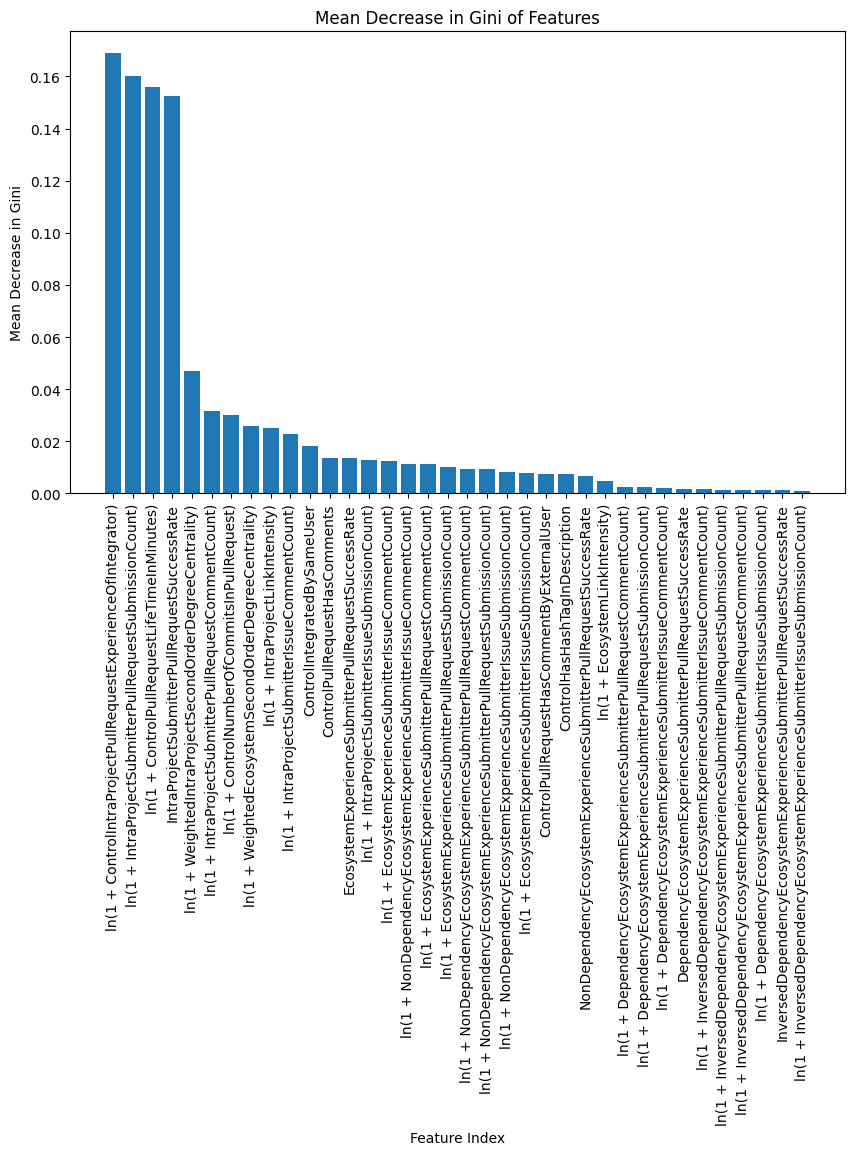

In [15]:
from matplotlib import pyplot as plt

feature_importances = full_rf_model.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]

# Step 4: Plot the mean decrease accuracy plot
plt.figure(figsize=(10, 6))
plt.bar(range(test_predictors.shape[1]), sorted_importances)
plt.xlabel("Feature Index")
plt.ylabel("Mean Decrease in Gini")
plt.title("Mean Decrease in Gini of Features")
ordererd_columns = np.array(test_predictors.columns)[sorted_indices]
plt.xticks(range(test_predictors.shape[1]), ordererd_columns, rotation=90)
plt.tight_layout()
plt.show()

In [16]:
# Stores feature importances in file.
output_file = f"{figure_base_path}/feature_importance.txt"
with open(output_file, "w+", encoding="utf-8") as output_file:
    for field, importance in zip(ordererd_columns, sorted_importances):
        entry = f"{field}: {importance}"
        output_file.write(f'{entry}\n')
        print(entry)

ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator): 0.16887180303703742
ln(1 + IntraProjectSubmitterPullRequestSubmissionCount): 0.16025196777716644
ln(1 + ControlPullRequestLifeTimeInMinutes): 0.15586514137754984
IntraProjectSubmitterPullRequestSuccessRate: 0.15255713125022058
ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality): 0.04693709128646645
ln(1 + IntraProjectSubmitterPullRequestCommentCount): 0.031663149685790974
ln(1 + ControlNumberOfCommitsInPullRequest): 0.030189530965508866
ln(1 + WeightedEcosystemSecondOrderDegreeCentrality): 0.025674819105709554
ln(1 + IntraProjectLinkIntensity): 0.025000849568079197
ln(1 + IntraProjectSubmitterIssueCommentCount): 0.022950980246399248
ControlIntegratedBySameUser: 0.01831955950106314
ControlPullRequestHasComments: 0.013661230061826074
EcosystemExperienceSubmitterPullRequestSuccessRate: 0.013396232394107614
ln(1 + IntraProjectSubmitterIssueSubmissionCount): 0.012686461514547212
ln(1 + EcosystemExperienceSubmitterIssueComment

### Variable Group Reverse Ablation Studies

Creates a model with a subset of features.
Compared to regular ablation, it tests "what happens if I add a feature", instead of "what happens when I remove one".

In [17]:
rev_abl_results = dict()

for cluster_name, cluster in var_groups.items():
    print(f'Reverse ablation with "{str(cluster_name)}", including: {cluster}.')

    # Creates models
    f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
        df, cluster, k, pr_merged_key, seed_counter
    )
    rev_abl_results[cluster_name] = (f1_scores, f1_mean, f1_std)

    print(
        f"Performance of '{cluster_name}'\n{list(cluster)}\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n"
    )

Reverse ablation with "FeatureGroups.Control", including: ['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)'].


random_state=50

random_state=50

random_state=50

random_state=50

random_state=50

metrics={'accuracy': 0.860479993919317, 'precision': 0.8964227539970498, 'recall': 0.9467579261359441, 'f1': 0.9209030418592291}


Confusion matrix:
[[  7623  14816]
 [  7211 128227]]


Classification report:

metrics={'accuracy': 0.8599804912654074, 'precision': 0.8951818828749634, 'recall': 0.9476926258567715, 'f1': 0.9206891355668291}


Confusion matrix:
[[  7462  15024]
 [  7082 128310]]


Classification report:

              precision    recall  f1-score   support

       False       0.51      0.34      0.41     22439
        True       0.90      0.95      0.92    135438

    accuracy                           0.86    157877
   macro avg       0.71      0.64      0.66    157877
weighted avg       0.84      0.86      0.85    157877


metrics={'accuracy': 0.8606392277581424, 'precision': 0.8954309050926734, 'recall': 0.9480889059716606, 'f1': 0.9210078482339679}


Confusion matrix:
[[  7610  14979]
 [  7023 128266]]


Classification report:

              precision    recall  f1-score   support

       False       0.51      0.33      0.40     22486
        True       0.90      0.95      0.92    135392

    accuracy                           0.86    157878
   macro avg       0.70      0.64      0.66    157878
weighted avg       0.84      0.86      0.85    157878


              precision    recall  f1-score   support

       False       0.52      0.34      0.41     22589
        True       0.90      0.95      0.92    135289

    accuracy                           0.86    157878
   macro avg       0.71      0.64      0.66    157878
weighted avg       0.84      0.86      0.85    157878


metrics={'accuracy': 0.8603161935165128, 'precision': 0.8961980325483118, 'recall': 0.9466620352236026, 'f1': 0.9207390927747607}


Confusion matrix:
[[  7735  14836]
 [  7217 128090]]


Classification report:

metrics={'accuracy': 0.8591317346305375, 'precision': 0.8946923136086814, 'recall': 0.9468761331093631, 'f1': 0.9200448669092165}


Confusion matrix:
[[  7680  15061]
 [  7179 127958]]


Classification report:

              precision    recall  f1-score   support

       False       0.52      0.34      0.41     22571
        True       0.90      0.95      0.92    135307

    accuracy                           0.86    157878
   macro avg       0.71      0.64      0.67    157878
weighted avg       0.84      0.86      0.85    157878


              precision    recall  f1-score   support

       False       0.52      0.34      0.41     22741
        True       0.89      0.95      0.92    135137

    accuracy                           0.86    157878
   macro avg       0.71      0.64      0.66    157878
weighted avg       0.84      0.86      0.85    157878


Performance of 'FeatureGroups.Control'
['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)']
f1_scores=[0.9209030418592291, 0.9206891355668291, 0.9210078482339679, 0.9207390927747607, 0.9200448669092165]
f1_mean=0.9206767970688006, f1_std=0.00033590186044775156

Reverse ablation with "FeatureGroups.Intra", including: ['IntraProjectSubmitterPullRequestSuccessRate', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + IntraProjectSubmitterIssueSubmissionCount)', 'ln(1 + IntraProjectSubmitterIssueCommentCount)'].


random_state=52

random_state=52

random_state=52

random_state=52

random_state=52

metrics={'accuracy': 0.8629891435158793, 'precision': 0.8803659819018467, 'recall': 0.9721166220434004, 'f1': 0.9239691672847035}


Confusion matrix:
[[  4811  17861]
 [  3770 131436]]


Classification report:

              precision    recall  f1-score   support

       False       0.56      0.21      0.31     22672
        True       0.88      0.97      0.92    135206

    accuracy                           0.86    157878
   macro avg       0.72      0.59      0.62    157878
weighted avg       0.83      0.86      0.84    157878


metrics={'accuracy': 0.8632425037053928, 'precision': 0.8805545704554731, 'recall': 0.9723654849340171, 'f1': 0.9241854438580414}


Confusion matrix:
[[  4689  17851]
 [  3740 131598]]


Classification report:

metrics={'accuracy': 0.863900378142478, 'precision': 0.881104929469026, 'recall': 0.972453744753798, 'f1': 0.9245283681590992}


Confusion matrix:
[[  4782  17759]
 [  3728 131608]]


Classification report:

              precision    recall  f1-score   support

       False       0.56      0.21      0.30     22540
        True       0.88      0.97      0.92    135338

    accuracy                           0.86    157878
   macro avg       0.72      0.59      0.61    157878
weighted avg       0.83      0.86      0.84    157878


              precision    recall  f1-score   support

       False       0.56      0.21      0.31     22541
        True       0.88      0.97      0.92    135336

    accuracy                           0.86    157877
   macro avg       0.72      0.59      0.62    157877
weighted avg       0.84      0.86      0.84    157877


metrics={'accuracy': 0.8642496104587086, 'precision': 0.8813352875432503, 'recall': 0.9726643573058771, 'f1': 0.9247503616420656}


Confusion matrix:
[[  4756  17731]
 [  3701 131690]]


Classification report:

              precision    recall  f1-score   support

       False       0.56      0.21      0.31     22487
        True       0.88      0.97      0.92    135391

    accuracy                           0.86    157878
   macro avg       0.72      0.59      0.62    157878
weighted avg       0.84      0.86      0.84    157878


metrics={'accuracy': 0.864464966619795, 'precision': 0.8816311486395926, 'recall': 0.9723930461520267, 'f1': 0.9247905185018559}


Confusion matrix:
[[  4923  17663]
 [  3735 131557]]


Classification report:

              precision    recall  f1-score   support

       False       0.57      0.22      0.32     22586
        True       0.88      0.97      0.92    135292

    accuracy                           0.86    157878
   macro avg       0.73      0.60      0.62    157878
weighted avg       0.84      0.86      0.84    157878


Performance of 'FeatureGroups.Intra'
['IntraProjectSubmitterPullRequestSuccessRate', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + IntraProjectSubmitterIssueSubmissionCount)', 'ln(1 + IntraProjectSubmitterIssueCommentCount)']
f1_scores=[0.9239691672847035, 0.9241854438580414, 0.9245283681590992, 0.9247503616420656, 0.9247905185018559]
f1_mean=0.9244447718891532, f1_std=0.000320426253956653

Reverse ablation with "FeatureGroups.Eco", including: ['EcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterIssueCommentCount)'].


random_state=54

random_state=54

random_state=54

random_state=54

random_state=54

metrics={'accuracy': 0.8529307439921965, 'precision': 0.8637245802042022, 'recall': 0.9835614818318895, 'f1': 0.9197560090546214}


Confusion matrix:
[[  1591  20995]
 [  2224 133068]]


Classification report:

metrics={'accuracy': 0.8535831464801936, 'precision': 0.8639042118242586, 'recall': 0.9841421220723917, 'f1': 0.9201116970907608}


metrics={'accuracy': 0.8542102129492393, 'precision': 0.8646464777580186, 'recall': 0.9840307271854342, 'f1': 0.9204837924017922}


Confusion matrix:
[[  1643  20971]
 [  2145 133119]]


Confusion matrix:
[[  1638  20855]
 [  2162 133223]]


Classification report:

Classification report:

metrics={'accuracy': 0.853874510698134, 'precision': 0.8645206565387464, 'recall': 0.9835881361445427, 'f1': 0.9202188362393918}


Confusion matrix:
[[  1760  20850]
 [  2220 133048]]


Classification report:

metrics={'accuracy': 0.8543739746764887, 'precision': 0.8650164051586915, 'recall': 0.9836355039378223, 'f1': 0.9205203461138247}


Confusion matrix:
[[  1747  20776]
 [  2215 133139]]


Classification report:

              precision    recall  f1-score   support

       False       0.42      0.07      0.12     22586
        True       0.86      0.98      0.92    135292

    accuracy                           0.85    157878
   macro avg       0.64      0.53      0.52    157878
weighted avg       0.80      0.85      0.81    157878


              precision    recall  f1-score   support

       False       0.43      0.07      0.12     22493
        True       0.86      0.98      0.92    135385

    accuracy                           0.85    157878
   macro avg       0.65      0.53      0.52    157878
weighted avg       0.80      0.85      0.81    157878


              precision    recall  f1-score   support

       False       0.43      0.07      0.12     22614
        True       0.86      0.98      0.92    135264

    accuracy                           0.85    157878
   macro avg       0.65      0.53      0.52    157878
weighted avg       0.80      0.85      0.81    157878


              precision    recall  f1-score   support

       False       0.44      0.08      0.13     22610
        True       0.86      0.98      0.92    135268

    accuracy                           0.85    157878
   macro avg       0.65      0.53      0.53    157878
weighted avg       0.80      0.85      0.81    157878


              precision    recall  f1-score   support

       False       0.44      0.08      0.13     22523
        True       0.87      0.98      0.92    135354

    accuracy                           0.85    157877
   macro avg       0.65      0.53      0.53    157877
weighted avg       0.80      0.85      0.81    157877


Performance of 'FeatureGroups.Eco'
['EcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterIssueCommentCount)']
f1_scores=[0.9197560090546214, 0.9204837924017922, 0.9201116970907608, 0.9202188362393918, 0.9205203461138247]
f1_mean=0.9202181361800781, f1_std=0.0002781349751797398

Reverse ablation with "FeatureGroups.DEco", including: ['DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)'].


random_state=56

random_state=56

random_state=56

random_state=56

random_state=56

metrics={'accuracy': 0.8556607000342036, 'precision': 0.8572073217236558, 'recall': 0.9976256342737104, 'f1': 0.9221013625766578}


Confusion matrix:
[[   217  22467]
 [   321 134873]]


Classification report:

metrics={'accuracy': 0.8572885392518274, 'precision': 0.859075972618586, 'recall': 0.9973509445100354, 'f1': 0.9230637896828785}


Confusion matrix:
[[   186  22172]
 [   359 135161]]


Classification report:

              precision    recall  f1-score   support

       False       0.40      0.01      0.02     22684
        True       0.86      1.00      0.92    135194

    accuracy                           0.86    157878
   macro avg       0.63      0.50      0.47    157878
weighted avg       0.79      0.86      0.79    157878


              precision    recall  f1-score   support

       False       0.34      0.01      0.02     22358
        True       0.86      1.00      0.92    135520

    accuracy                           0.86    157878
   macro avg       0.60      0.50      0.47    157878
weighted avg       0.79      0.86      0.79    157878


metrics={'accuracy': 0.8557367080910576, 'precision': 0.8571383188258466, 'recall': 0.9978475694547176, 'f1': 0.9221562207351001}


Confusion matrix:
[[   197  22485]
 [   291 134905]]


Classification report:

              precision    recall  f1-score   support

       False       0.40      0.01      0.02     22682
        True       0.86      1.00      0.92    135196

    accuracy                           0.86    157878
   macro avg       0.63      0.50      0.47    157878
weighted avg       0.79      0.86      0.79    157878


metrics={'accuracy': 0.8561357503895413, 'precision': 0.85757313880487, 'recall': 0.9977893935249192, 'f1': 0.922382949058364}


Confusion matrix:
[[   207  22414]
 [   299 134958]]


Classification report:

              precision    recall  f1-score   support

       False       0.41      0.01      0.02     22621
        True       0.86      1.00      0.92    135257

    accuracy                           0.86    157878
   macro avg       0.63      0.50      0.47    157878
weighted avg       0.79      0.86      0.79    157878


metrics={'accuracy': 0.8570722777858713, 'precision': 0.8584189427004911, 'recall': 0.997931992082484, 'f1': 0.9229329535480214}


Confusion matrix:
[[   196  22285]
 [   280 135116]]


Classification report:

              precision    recall  f1-score   support

       False       0.41      0.01      0.02     22481
        True       0.86      1.00      0.92    135396

    accuracy                           0.86    157877
   macro avg       0.64      0.50      0.47    157877
weighted avg       0.79      0.86      0.79    157877


Performance of 'FeatureGroups.DEco'
['DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)']
f1_scores=[0.9221013625766578, 0.9230637896828785, 0.9221562207351001, 0.922382949058364, 0.9229329535480214]
f1_mean=0.9225274551202045, f1_std=0.0003980792796263914

Reverse ablation with "FeatureGroups.IDEco", including: ['InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount)'

random_state=58

random_state=58

random_state=58

random_state=58

random_state=58

metrics={'accuracy': 0.8570605150812652, 'precision': 0.858232268715474, 'recall': 0.9982275134228932, 'f1': 0.9229513849767663}


Confusion matrix:
[[   148  22327]
 [   240 135163]]


Classification report:

              precision    recall  f1-score   support

       False       0.38      0.01      0.01     22475
        True       0.86      1.00      0.92    135403

    accuracy                           0.86    157878
   macro avg       0.62      0.50      0.47    157878
weighted avg       0.79      0.86      0.79    157878


metrics={'accuracy': 0.8568071548917519, 'precision': 0.8580438234360114, 'recall': 0.9981086771822245, 'f1': 0.9227916189955772}


Confusion matrix:
[[   172  22351]
 [   256 135099]]


Classification report:

              precision    recall  f1-score   support

       False       0.40      0.01      0.01     22523
        True       0.86      1.00      0.92    135355

    accuracy                           0.86    157878
   macro avg       0.63      0.50      0.47    157878
weighted avg       0.79      0.86      0.79    157878


metrics={'accuracy': 0.8563131025222007, 'precision': 0.8575710810930961, 'recall': 0.9980930136297785, 'f1': 0.9225114687125324}


Confusion matrix:
[[   159  22427]
 [   258 135034]]


Classification report:

metrics={'accuracy': 0.8559828220703459, 'precision': 0.857250827241491, 'recall': 0.9980700405217545, 'f1': 0.9223163310977256}


Confusion matrix:
[[   165  22476]
 [   261 134975]]


Classification report:

              precision    recall  f1-score   support

       False       0.38      0.01      0.01     22586
        True       0.86      1.00      0.92    135292

    accuracy                           0.86    157878
   macro avg       0.62      0.50      0.47    157878
weighted avg       0.79      0.86      0.79    157878


              precision    recall  f1-score   support

       False       0.39      0.01      0.01     22641
        True       0.86      1.00      0.92    135236

    accuracy                           0.86    157877
   macro avg       0.62      0.50      0.47    157877
weighted avg       0.79      0.86      0.79    157877


metrics={'accuracy': 0.8562054244416575, 'precision': 0.8575012543903663, 'recall': 0.9980336642592607, 'f1': 0.9224457167844112}


Confusion matrix:
[[   165  22436]
 [   266 135011]]


Classification report:

              precision    recall  f1-score   support

       False       0.38      0.01      0.01     22601
        True       0.86      1.00      0.92    135277

    accuracy                           0.86    157878
   macro avg       0.62      0.50      0.47    157878
weighted avg       0.79      0.86      0.79    157878


Performance of 'FeatureGroups.IDEco'
['InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount)']
f1_scores=[0.9229513849767663, 0.9227916189955772, 0.9225114687125324, 0.9223163310977256, 0.9224457167844112]
f1_mean=0.9226033041134025, f1_std=0.0002333425812520404

Reverse ablation with "FeatureGroups.NDEco", including: ['NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterIs

random_state=60

random_state=60

random_state=60

random_state=60

random_state=60

metrics={'accuracy': 0.8544255691103257, 'precision': 0.8637491336144633, 'recall': 0.9855941223427845, 'f1': 0.9206577162209281}


Confusion matrix:
[[  1552  21034]
 [  1949 133343]]


Classification report:

              precision    recall  f1-score   support

       False       0.44      0.07      0.12     22586
        True       0.86      0.99      0.92    135292

    accuracy                           0.85    157878
   macro avg       0.65      0.53      0.52    157878
weighted avg       0.80      0.85      0.81    157878


metrics={'accuracy': 0.8539559277158801, 'precision': 0.8638013507732594, 'recall': 0.9848942821458396, 'f1': 0.9203819126711441}


Confusion matrix:
[[  1551  21013]
 [  2044 133269]]


Classification report:

              precision    recall  f1-score   support

       False       0.43      0.07      0.12     22564
        True       0.86      0.98      0.92    135313

    accuracy                           0.85    157877
   macro avg       0.65      0.53      0.52    157877
weighted avg       0.80      0.85      0.81    157877


metrics={'accuracy': 0.8535008044186017, 'precision': 0.8634484278196853, 'recall': 0.9847887948556857, 'f1': 0.920135495833952}


Confusion matrix:
[[  1512  21071]
 [  2058 133237]]


Classification report:

              precision    recall  f1-score   support

       False       0.42      0.07      0.12     22583
        True       0.86      0.98      0.92    135295

    accuracy                           0.85    157878
   macro avg       0.64      0.53      0.52    157878
weighted avg       0.80      0.85      0.81    157878


metrics={'accuracy': 0.854102534868696, 'precision': 0.8634847002572094, 'recall': 0.9854851709171035, 'f1': 0.9204599606339997}


Confusion matrix:
[[  1566  21071]
 [  1963 133278]]


Classification report:

              precision    recall  f1-score   support

       False       0.44      0.07      0.12     22637
        True       0.86      0.99      0.92    135241

    accuracy                           0.85    157878
   macro avg       0.65      0.53      0.52    157878
weighted avg       0.80      0.85      0.81    157878


metrics={'accuracy': 0.8545395811956067, 'precision': 0.8644929180306615, 'recall': 0.9847809070904284, 'f1': 0.9207247822649964}


Confusion matrix:
[[  1552  20904]
 [  2061 133361]]


Classification report:

              precision    recall  f1-score   support

       False       0.43      0.07      0.12     22456
        True       0.86      0.98      0.92    135422

    accuracy                           0.85    157878
   macro avg       0.65      0.53      0.52    157878
weighted avg       0.80      0.85      0.81    157878


Performance of 'FeatureGroups.NDEco'
['NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount)']
f1_scores=[0.9206577162209281, 0.9203819126711441, 0.920135495833952, 0.9204599606339997, 0.9207247822649964]
f1_mean=0.920471973525004, f1_std=0.00020970699159999972

Reverse ablation with "FeatureGroups.Coll", including: ['ln(1 + WeightedEcosystemSecondOrderDegreeCentrality)', 'ln(1 + EcosystemLinkIntensity)'].


random_state=62

random_state=62

random_state=62

random_state=62

random_state=62

metrics={'accuracy': 0.8393253018153257, 'precision': 0.8637828892933973, 'recall': 0.9646077880606724, 'f1': 0.9114153911698253}


Confusion matrix:
[[  2015  20579]
 [  4788 130496]]


Classification report:

              precision    recall  f1-score   support

       False       0.30      0.09      0.14     22594
        True       0.86      0.96      0.91    135284

    accuracy                           0.84    157878
   macro avg       0.58      0.53      0.52    157878
weighted avg       0.78      0.84      0.80    157878


metrics={'accuracy': 0.8389262595168421, 'precision': 0.8637411100957527, 'recall': 0.9641289082711213, 'f1': 0.9111783279311502}


Confusion matrix:
[[  2011  20577]
 [  4853 130437]]


Classification report:

              precision    recall  f1-score   support

       False       0.29      0.09      0.14     22588
        True       0.86      0.96      0.91    135290

    accuracy                           0.84    157878
   macro avg       0.58      0.53      0.52    157878
weighted avg       0.78      0.84      0.80    157878


metrics={'accuracy': 0.8388882554884151, 'precision': 0.863713144454528, 'recall': 0.9640514902143454, 'f1': 0.9111281925858635}


Confusion matrix:
[[  2055  20574]
 [  4862 130387]]


Classification report:

              precision    recall  f1-score   support

       False       0.30      0.09      0.14     22629
        True       0.86      0.96      0.91    135249

    accuracy                           0.84    157878
   macro avg       0.58      0.53      0.53    157878
weighted avg       0.78      0.84      0.80    157878


metrics={'accuracy': 0.8386022029808015, 'precision': 0.8636405804784308, 'recall': 0.9637445927459607, 'f1': 0.9109507417568016}


Confusion matrix:
[[  2064  20578]
 [  4903 130332]]


Classification report:

              precision    recall  f1-score   support

       False       0.30      0.09      0.14     22642
        True       0.86      0.96      0.91    135235

    accuracy                           0.84    157877
   macro avg       0.58      0.53      0.53    157877
weighted avg       0.78      0.84      0.80    157877


metrics={'accuracy': 0.8399840383080607, 'precision': 0.8646099300162722, 'recall': 0.9646138518873842, 'f1': 0.911878276702839}


Confusion matrix:
[[  1905  20468]
 [  4795 130710]]


Classification report:

              precision    recall  f1-score   support

       False       0.28      0.09      0.13     22373
        True       0.86      0.96      0.91    135505

    accuracy                           0.84    157878
   macro avg       0.57      0.52      0.52    157878
weighted avg       0.78      0.84      0.80    157878


Performance of 'FeatureGroups.Coll'
['ln(1 + WeightedEcosystemSecondOrderDegreeCentrality)', 'ln(1 + EcosystemLinkIntensity)']
f1_scores=[0.9114153911698253, 0.9111783279311502, 0.9111281925858635, 0.9109507417568016, 0.911878276702839]
f1_mean=0.9113101860292959, f1_std=0.0003204694966727651



In [18]:
# Prints summarized results again for clarity.
print("Reverse cluster ablation results:")
for cluster_name, (f1_scores, f1_mean, f1_std) in rev_abl_results.items():
    print(f"Cluster '{cluster_name}':\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n")

Reverse cluster ablation results:
Cluster 'FeatureGroups.Control':
f1_scores=[0.9209030418592291, 0.9206891355668291, 0.9210078482339679, 0.9207390927747607, 0.9200448669092165]
f1_mean=0.9206767970688006, f1_std=0.00033590186044775156

Cluster 'FeatureGroups.Intra':
f1_scores=[0.9239691672847035, 0.9241854438580414, 0.9245283681590992, 0.9247503616420656, 0.9247905185018559]
f1_mean=0.9244447718891532, f1_std=0.000320426253956653

Cluster 'FeatureGroups.Eco':
f1_scores=[0.9197560090546214, 0.9204837924017922, 0.9201116970907608, 0.9202188362393918, 0.9205203461138247]
f1_mean=0.9202181361800781, f1_std=0.0002781349751797398

Cluster 'FeatureGroups.DEco':
f1_scores=[0.9221013625766578, 0.9230637896828785, 0.9221562207351001, 0.922382949058364, 0.9229329535480214]
f1_mean=0.9225274551202045, f1_std=0.0003980792796263914

Cluster 'FeatureGroups.IDEco':
f1_scores=[0.9229513849767663, 0.9227916189955772, 0.9225114687125324, 0.9223163310977256, 0.9224457167844112]
f1_mean=0.9226033041134025

### Probability Guesser

Guesses the outcome by simply considering the probability of a merged pull request.
Technically, an RF model performs somewhat well when its performance scores are ``> 0.5`` as there are only two possible outcomes.
However, they actually mean anything once it's better than a simple probability guesser.

In [19]:
import random

from python_proj.modelling.notebooks.random_forest.rf_functions import calculate_metrics

random.seed(seed_counter.get_next())

probability_true = class_imbalance / (class_imbalance + 1)

predictions = [random.random() < probability_true for _ in range(len(test_dependent))]
metrics = calculate_metrics(predictions, test_dependent)

print(f"Probability guesser metrics with {probability_true=}.")
print(json.dumps(metrics, indent=4))

Probability guesser metrics with probability_true=0.8570717352281322.
{
    "accuracy": 0.7551970508873941,
    "precision": 0.8564590827504192,
    "recall": 0.8578340706982526,
    "f1": 0.857146025304104
}


In [20]:
import datetime

print(datetime.datetime.now())

2024-02-21 11:53:23.191269
